In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12


In [ ]:
tweets_path = r"e:/price prediction/Datasets/tweets_premier_league_footballers.csv"

encodings = ['utf-8','latin1','cp1252','ISO-8859-1']
tweets = None

for enc in encodings:
    try:
        tweets = pd.read_csv(tweets_path, encoding=enc, low_memory=False)
        print("Loaded using:", enc)
        break
    except:
        pass

if tweets is None:
    raise FileNotFoundError("Cannot read CSV")

print("Loaded:", tweets.shape)
tweets.head()


Loaded using: latin1
Loaded: (167841, 9)


,player_name,text,vader_polarity,vader_emotion,tb_polarity,tb_emotion,game_date,tweet_date,when
0,SCOTT CARSON,Maple Leafs No wonder they re cursed,-0.2960,negative,0.0,neutral,2023-04-30,2023-04-29,before
1,SCOTT CARSON,scott carson scott carson and scott carson,0.0000,neutral,0.0,neutral,2023-04-30,2023-04-29,before
2,SCOTT CARSON,Scott Carson the goat,0.0000,neutral,0.0,neutral,2023-04-30,2023-04-29,before
3,SCOTT CARSON,And a snicker to sign Scott Carson and you d u...,-0.3400,negative,0.0,neutral,2023-04-30,2023-04-29,before
4,SCOTT CARSON,Just keep throwing 100 amp pitch partial seaso...,0.5106,positive,0.3,positive,2023-04-30,2023-04-29,before


In [8]:
# Auto-detect likely text column
text_candidates = [c for c in tweets.columns if c.lower() in ('text','tweet','tweet_text','full_text','content')]
if text_candidates:
    text_col = text_candidates[0]
else:
    # fallback: choose string column with largest average length
    str_cols = [c for c in tweets.columns if tweets[c].dtype == object]
    if str_cols:
        avg_len = {c: tweets[c].astype(str).map(len).mean() for c in str_cols}
        text_col = max(avg_len, key=avg_len.get)
    else:
        text_col = None

# Auto-detect player column
player_candidates = [c for c in tweets.columns if 'player' in c.lower() or 'name' in c.lower()]
if player_candidates:
    player_col = player_candidates[0]
else:
    # try author-like columns
    player_col = next((c for c in tweets.columns if any(k in c.lower() for k in ('author','user','screen','handle'))), None)

# If still none, create placeholder
if player_col is None:
    tweets['player_name'] = 'unknown'
    player_col = 'player_name'

# Create a cleaned text column we will use for vectorizing
if text_col is None:
    tweets['text_for_sent'] = ""
    text_col = 'text_for_sent'
else:
    tweets['text_for_sent'] = tweets[text_col].astype(str).fillna("")

print("Using text column:", text_col)
print("Using player column:", player_col)


Using text column: text
Using player column: player_name


In [9]:
# If a Vader-like numeric column exists, use it to label tweets; otherwise fallback.
vader_col = next((c for c in tweets.columns if 'vader' in c.lower() or 'compound' in c.lower() or 'polarity' in c.lower()), None)

def vader_to_label(x):
    try:
        x = float(x)
    except:
        return 'neutral'
    if x >= 0.05:
        return 'positive'
    if x <= -0.05:
        return 'negative'
    return 'neutral'

if vader_col is not None:
    tweets['label'] = tweets[vader_col].map(vader_to_label)
else:
    # quick heuristic if no vader: simple keyword-based labeling (very rough)
    def quick_label(s):
        s = str(s).lower()
        if any(w in s for w in ('good','great','love','fantastic','best','win','nice','amazing','goat')):
            return 'positive'
        if any(w in s for w in ('bad','hate','terrible','worst','injury','injured','lose','dislike','curse')):
            return 'negative'
        return 'neutral'
    tweets['label'] = tweets['text_for_sent'].map(quick_label)

# show label distribution
print("Label distribution:\n", tweets['label'].value_counts())


Label distribution:
 label
positive    74793
neutral     62009
negative    31039
Name: count, dtype: int64


In [12]:
# Vectorize text and train a TF-IDF + LogisticRegression model to generate probabilities for each tweet.
X = tweets['text_for_sent'].fillna("").astype(str)
y = tweets['label'].astype(str)

tf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_vec = tf.fit_transform(X)

# Check if there are at least 2 classes and some samples per class for train-test split
cls_counts = y.value_counts()
train_test_possible = (len(cls_counts) > 1) and (cls_counts.min() >= 5)

if train_test_possible:
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Classification report:\n", classification_report(y_test, y_pred))
    probs = clf.predict_proba(X_vec)
    classes = list(clf.classes_)
else:
    # If training is not reliable, convert categorical labels into one-hot probabilities as fallback
    classes = ['negative','neutral','positive']
    probs = np.zeros((len(tweets), len(classes)))
    for i, lab in enumerate(tweets['label'].astype(str)):
        if lab in classes:
            probs[i, classes.index(lab)] = 1.0
        else:
            probs[i, classes.index('neutral')] = 1.0

# attach probabilities to dataframe with column names according to classes
prob_df = pd.DataFrame(probs, columns=[f"prob_{c}" for c in classes])
tweets = pd.concat([tweets.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)


Classification report:
               precision    recall  f1-score   support

    negative       0.86      0.68      0.76      6208
     neutral       0.87      0.96      0.91     12402
    positive       0.91      0.91      0.91     14959

    accuracy                           0.89     33569
   macro avg       0.88      0.85      0.86     33569
weighted avg       0.89      0.89      0.88     33569



In [14]:
# Group by player and compute aggregated features for each player.
grp = tweets.groupby(player_col).agg(
    tweet_count = ('text_for_sent','count')
).reset_index()

# Add mean probabilities per player
for c in classes:
    pc = f'prob_{c}'
    if pc in tweets.columns:
        grp[pc] = tweets.groupby(player_col)[pc].mean().values

# Add predicted label ratios
grp['positive_ratio'] = tweets.groupby(player_col)['label'].apply(lambda s: (s=='positive').mean()).values
grp['negative_ratio'] = tweets.groupby(player_col)['label'].apply(lambda s: (s=='negative').mean()).values
grp['neutral_ratio'] = tweets.groupby(player_col)['label'].apply(lambda s: (s=='neutral').mean()).values

# sentiment volatility: std dev of prob_positive if present, else use mapped label std
if 'prob_positive' in tweets.columns:
    grp['sentiment_volatility'] = tweets.groupby(player_col)['prob_positive'].std().fillna(0).values
else:
    lab_map = {'positive':1, 'neutral':0, 'negative':-1}
    grp['sentiment_volatility'] = tweets.groupby(player_col)['label'].apply(lambda s: s.map(lab_map).std()).fillna(0).values

# sentiment_score: prefer prob_positive - prob_negative, else positive_ratio - negative_ratio
if 'prob_positive' in grp.columns and 'prob_negative' in grp.columns:
    grp['sentiment_score'] = grp['prob_positive'] - grp['prob_negative']
else:
    grp['sentiment_score'] = grp['positive_ratio'] - grp['negative_ratio']

# normalize sentiment_score to 0-1 (0 = most negative, 1 = most positive)
minv = grp['sentiment_score'].min()
maxv = grp['sentiment_score'].max()
if pd.isna(minv) or pd.isna(maxv) or minv == maxv:
    grp['sentiment_score_norm'] = 0.5
else:
    grp['sentiment_score_norm'] = (grp['sentiment_score'] - minv) / (maxv - minv)

# show top rows
grp = grp.sort_values('tweet_count', ascending=False).reset_index(drop=True)
display(grp.head(20))
# save per-player sentiment results
out_path = "sentiment_results_by_player.csv"
grp.to_csv(out_path, index=False)
print("Saved per-player sentiment to:", out_path)


,player_name,tweet_count,prob_negative,prob_neutral,prob_positive,positive_ratio,negative_ratio,neutral_ratio,sentiment_volatility,sentiment_score,sentiment_score_norm
0,ADAM SMITH,600,0.226536,0.286462,0.487002,0.480000,0.241667,0.278333,0.353041,0.260466,0.547137
1,ADRIAN,600,0.210780,0.354916,0.434304,0.423333,0.228333,0.348333,0.388033,0.223524,0.520548
2,LUIS DIAZ,600,0.236177,0.342851,0.420973,0.410000,0.253333,0.336667,0.364631,0.184796,0.492674
3,LUKE SHAW,600,0.181530,0.395083,0.423387,0.410000,0.190000,0.400000,0.379974,0.241857,0.533744
4,LISANDRO MARTINEZ,600,0.189310,0.295247,0.515442,0.506667,0.198333,0.295000,0.385492,0.326132,0.594400
5,BERNARDO SILVA,600,0.171349,0.314980,0.513670,0.526667,0.155000,0.318333,0.358017,0.342321,0.606052
6,BEN WHITE,600,0.247909,0.294563,0.457528,0.441667,0.268333,0.290000,0.359378,0.209619,0.510540
7,BEN JOHNSON,600,0.212014,0.293135,0.494851,0.506667,0.220000,0.273333,0.371239,0.282838,0.563239
8,BEN DAVIES,600,0.221426,0.322690,0.455885,0.450000,0.226667,0.323333,0.367859,0.234459,0.528419
9,ASHLEY YOUNG,600,0.188906,0.482719,0.328374,0.325000,0.205000,0.470000,0.366711,0.139468,0.460049


Saved per-player sentiment to: sentiment_results_by_player.csv


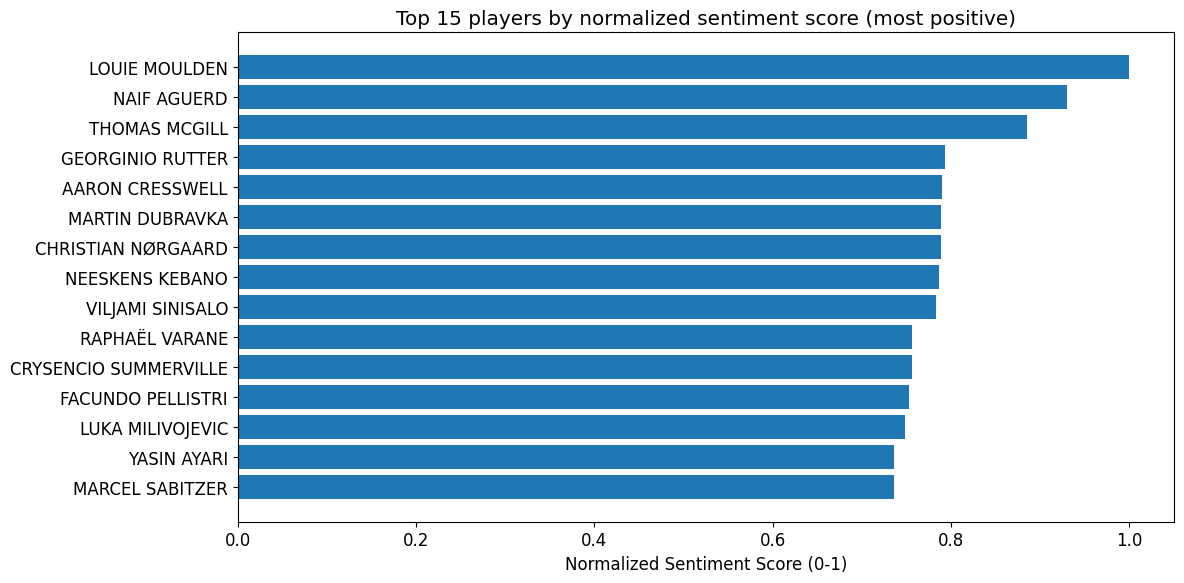

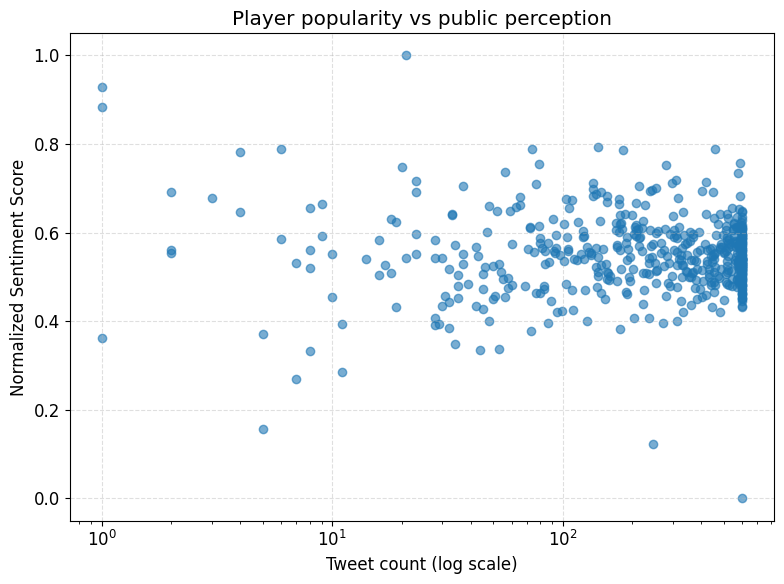

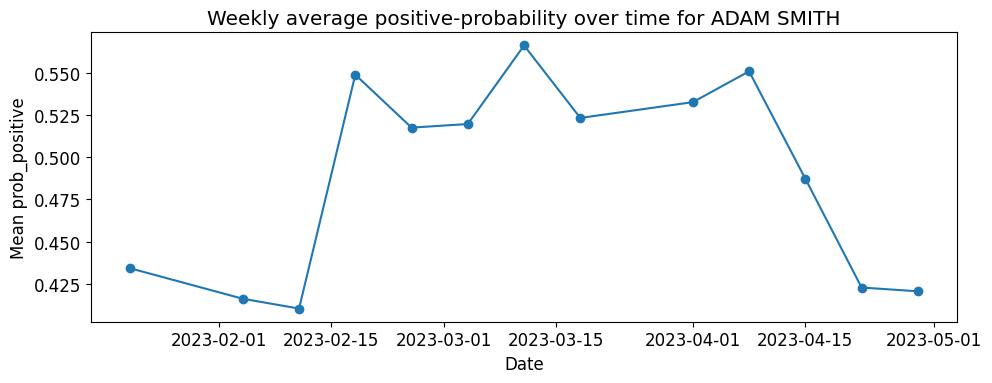

In [16]:
# 1) Bar chart: Top N players by tweet_count (popularity)
top_n = 15
top_by_count = grp.sort_values('tweet_count', ascending=False).head(top_n)

# 2) Bar chart: Top N players by sentiment_score_norm (most positive)
top_by_sent = grp.sort_values('sentiment_score_norm', ascending=False).head(top_n)
plt.figure(figsize=(12,6))
plt.barh(top_by_sent[player_col].astype(str)[::-1], top_by_sent['sentiment_score_norm'][::-1])
plt.xlabel("Normalized Sentiment Score (0-1)")
plt.title(f"Top {top_n} players by normalized sentiment score (most positive)")
plt.tight_layout()
plt.show()

# 3) Scatter: sentiment_score_norm vs tweet_count (to show popularity vs perception)
plt.figure(figsize=(8,6))
plt.scatter(grp['tweet_count'], grp['sentiment_score_norm'], alpha=0.6)
plt.xscale('log')  # many players have small counts, log helps visualization
plt.xlabel("Tweet count (log scale)")
plt.ylabel("Normalized Sentiment Score")
plt.title("Player popularity vs public perception")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4) Example time-series: if tweets include tweet_date, show sentiment over time for a sample player
date_col_candidates = [c for c in tweets.columns if 'date' in c.lower()]
if date_col_candidates:
    tweet_date_col = date_col_candidates[0]
    tweets[tweet_date_col] = pd.to_datetime(tweets[tweet_date_col], dayfirst=True, errors='coerce')
    sample_player = grp[player_col].iloc[0]  # top player by tweet_count
    df_sample = tweets[tweets[player_col] == sample_player].sort_values(tweet_date_col)
    if len(df_sample) > 0:
        # aggregate daily mean of prob_positive (if exists) else positive_ratio
        if 'prob_positive' in df_sample.columns:
            daily = df_sample.set_index(tweet_date_col).resample('7D')['prob_positive'].mean().dropna()
            plt.figure(figsize=(10,4))
            plt.plot(daily.index, daily.values, marker='o')
            plt.title(f"Weekly average positive-probability over time for {sample_player}")
            plt.ylabel("Mean prob_positive")
            plt.xlabel("Date")
            plt.tight_layout()
            plt.show()
        else:
            print("prob_positive not available for time-series plotting.")
    else:
        print("Not enough tweets for sample player time-series.")
else:
    print("No date column found for time-series plot.")


In [20]:

import pandas as pd, os, re
from unidecode import unidecode
from rapidfuzz import process, fuzz

# paths
merged_path = r"E:\price prediction\merged_ml.csv.gz"
out_path = r"E:\price prediction\merged_ml_with_sentiment_core.csv.gz"

# load merged_ml and grp (assumes grp exists)
merged_ml = pd.read_csv(merged_path, low_memory=False)
if 'grp' not in globals():
    raise RuntimeError("Sentiment dataframe 'grp' not found. Run aggregation cell first.")

# required sentiment columns to keep
core_cols = ['sentiment_score_norm','tweet_count','positive_ratio','negative_ratio','sentiment_volatility']

# Ensure grp contains at least one of the core cols
present_core = [c for c in core_cols if c in grp.columns]
if not present_core:
    raise ValueError(f"None of required sentiment cols found in grp. Expected at least one of: {core_cols}")

# detect actual player_name column names
mm_player_col = next((c for c in merged_ml.columns if 'player' in c.lower() and 'name' in c.lower()), None)
grp_player_col = next((c for c in grp.columns if 'player' in c.lower() and 'name' in c.lower()), None)
if mm_player_col is None or grp_player_col is None:
    raise ValueError("Missing player_name column in merged_ml or grp. Ensure both have player_name-like column.")

# Normalization function
def normalize_name(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = unidecode(s)              
    s = s.lower()               
    s = re.sub(r"[^\w\s]", " ", s) 
    s = re.sub(r"\b(k\.)\b", "k", s) 
    s = re.sub(r"\s+", " ", s)    
    s = s.strip()
    return s


merged_ml['_player_key'] = merged_ml[mm_player_col].astype(str).map(normalize_name)
grp['_player_key'] = grp[grp_player_col].astype(str).map(normalize_name)

cols_to_merge = ['_player_key'] + present_core
grp_small = grp[['_player_key'] + present_core].drop_duplicates(subset=['_player_key']).reset_index(drop=True)

merged_exact = merged_ml.merge(grp_small, on='_player_key', how='left', suffixes=('','_sent'))
exact_matched = merged_exact['_player_key'].notna() & merged_exact['tweet_count'].notna() if 'tweet_count' in merged_exact.columns else merged_exact['_player_key'].notna() & merged_exact[present_core[0]].notna()

exact_matches_count = merged_exact[present_core[0]].notna().sum()

# 2) Prepare list of unmatched rows to fuzzy match
unmatched_mask = merged_exact[present_core[0]].isna()
unmatched_keys = merged_exact.loc[unmatched_mask, '_player_key'].unique().tolist()
grp_keys = grp_small['_player_key'].tolist()

# Fuzzy match function with threshold
threshold = 85  
mapping = {}    
fuzzy_matches = 0

# For speed, build index dict for grp_small rows
grp_index = {k:i for i,k in enumerate(grp_small['_player_key'].tolist())}

for mk in unmatched_keys:
    if not mk: 
        continue
    # find best match
    best = process.extractOne(mk, grp_keys, scorer=fuzz.WRatio)
    if best is None:
        continue
    match_key, score, _ = best
    if score >= threshold:
        mapping[mk] = match_key
        fuzzy_matches += 1

# Apply fuzzy mapping to create a dataframe of fuzzy matches to merge
if mapping:
    # construct a small df: merged_ml_key -> grp values
    mapped_rows = []
    for mkey, gkey in mapping.items():
        row = grp_small[grp_small['_player_key'] == gkey]
        if not row.empty:
            r = row.iloc[0].to_dict()
            r['_player_key'] = mkey  # set to merged_ml key so merge works
            mapped_rows.append(r)
    if mapped_rows:
        grp_fuzzy = pd.DataFrame(mapped_rows)
        # combine exact grp_small and fuzzy grp_fuzzy (fuzzy overrides only for mapped keys)
        grp_combined = pd.concat([grp_small, grp_fuzzy], ignore_index=True).drop_duplicates(subset=['_player_key'], keep='first')
    else:
        grp_combined = grp_small.copy()
else:
    grp_combined = grp_small.copy()

# Final merge using combined mapping
merged_final = merged_ml.merge(grp_combined, on='_player_key', how='left', suffixes=('','_sent'))

# Diagnostics
exact_matches_after = merged_final[present_core[0]].notna().sum()
total_matched = exact_matches_after
print("Exact matches (before fuzzy):", exact_matches_count)
print("Fuzzy matches applied:", fuzzy_matches)
print("Total rows matched with sentiment after fuzzy:", total_matched, "out of", len(merged_final))

# Show sample unmatched names if many remain
still_unmatched = merged_final[merged_final[present_core[0]].isna()].head(20)
if len(still_unmatched) > 0:
    print("\nSample still-unmatched players (first 20):")
    display(still_unmatched[[mm_player_col, '_player_key']].drop_duplicates().head(20))

# Keep only core sentiment cols + original merged_ml columns (avoid adding many columns)
keep_cols = list(merged_ml.columns) + present_core
# ensure no duplicate column names; drop any duplicate cols from merged_final not in keep
merged_final_reduced = merged_final[ list(merged_ml.columns) + [c for c in present_core if c in merged_final.columns] ]

# Save compressed
merged_final_reduced.to_csv(out_path, index=False, compression='gzip')
print("\nSaved merged file with core sentiment features to:", out_path)


Exact matches (before fuzzy): 0
Fuzzy matches applied: 24646
Total rows matched with sentiment after fuzzy: 25165 out of 92671

Sample still-unmatched players (first 20):


,player_name,_player_key
0,Silvio Adzic (1),silvio adzic 1
2,Miroslav Klose (10),miroslav klose 10
5,Sodick Adejumo (1000152),sodick adejumo 1000152
8,Sergiy Zagynaylov (100020),sergiy zagynaylov 100020
9,Lenny Stoltz (1000161),lenny stoltz 1000161
10,Facundo Canete (1000253),facundo canete 1000253
11,Brian Romero (1000274),brian romero 1000274
12,Nimfasha Berchimas (1000273),nimfasha berchimas 1000273
13,Malcolm Rangon (1000148),malcolm rangon 1000148
15,Joselu Pérez (1000135),joselu perez 1000135



Saved merged file with core sentiment features to: E:\price prediction\merged_ml_with_sentiment_core.csv.gz
